# L12.1 PCA(Principal Component Analysis) Practice
---
이름: 김태산

학과: 자동차공학과

학번: 20143211

---

### 과제 목표: 데이터의 주성분을 찾고, 이를 이용하여 데이터의 차원을 축소시켜본다.

### 모듈 불러오기
- 사용할 모듈 import 하기

In [ ]:
import torch
import requests
import matplotlib.pyplot as plt

### Iris dataset
- 아이리스(붓꽃) 데이터
 - 붓꽃 종류별로 꽃받침과 꽃잎의 길이 및 너비를 측정한 데이터셋이다.
 - 데이터셋의 각 샘플은 꽃받침과 꽃잎의 길이 및 너비의 4차원 특징 벡터와 해당 샘플의 레이블이 ','로 구분되어 있다.

### 데이터 불러오기
- Iris 클래스를 생성하여 Iris 데이터셋의 특징 벡터와 레이블을 저장한다.

In [ ]:
iris_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
r = requests.get(iris_url) # requests.get()을 사용하면 해당 url로부터 데이터를 직접 불러올 수 있다.
# 위에서 불러온 데이터를 파일로 저장한다.
with open("iris.data", 'wb') as f:
  f.write(r.content)

vectors = []
answers = []

with open("iris.data", 'r') as f:
  for line in f:
    if len(line.strip()) == 0: continue # 마지막의 비어있는 줄을 제외한다.
    items = line.strip().split(',')
    vectors.append([float(item) for item in items[:-1]]) # iris 데이터 중 특징벡터를 분리하여 vectors에 입력한다.
    answers.append(items[-1])                            # iris 데이터 중 label을 분리하여 answers에 입력한다.

### Tensor로 변환, 중심 옮기기

In [ ]:
# iris의 특징벡터를 텐서로 변환하고 계산을 용이하게 하기 위해 전체 벡터에 대해 각각의 차원의 평균을 빼줌으로써 특징벡터의 중심점을 원점으로 옮긴다.
X = torch.FloatTensor(vectors)
Z = X - X.mean(axis=0)

### findPC(): 주성분 찾기 함수
- 분산을 최대로 하는 w벡터 찾기

In [ ]:
# 주성분 벡터를 찾기 위한 함수를 구현한다.
def findPC(Z):
  w = torch.randn(Z.shape[1])
  w = w / ((w ** 2).sum() ** 0.5) # w를 w의 크기로 나누어 w가 단위벡터가 되도록 만든다.

  lr = 0.1

  for epoch in range(1001):
    w.requires_grad_(True)

    variance = ((Z * w).sum(axis=1) ** 2).mean() # 이번 과제에서 분산을 구할 때는 Z를 w에 내적시켜 얻은 길이 값을 제곱하고 이를 모든 점에 대해 평균하여 구한다.
    variance.backward()

    with torch.no_grad():
      w = w + lr * w.grad               # 일반적인 학습과 다르게 variance는 클수록 성능이 좋은 것이기 때문에 그레디언트가 증가하는 방향으로 갱신한다.
      w = w / ((w ** 2).sum() ** 0.5) # w의 크기를 다시 1이 되도록 한다.
  
  return w, variance.item()

### PCA
- 순서대로 주성분 찾기

In [ ]:
# n개의 주성분을 찾기 위한 함수를 구현한다.
def PCA(Z, n):
  W, V = [], []

  for _ in range(n):
    w, v = findPC(Z)
    W.append(w.tolist())
    V.append(v)

    Z = Z - (Z * w).sum(axis=1).view(-1, 1) * w # 특징벡터 Z와 w를 내적하여 구한 길이에 w를 곱하면 w 방향의 Z 성분을 구하고 이를 Z에서 빼줌으로서 주성분 요소를 Z에서 제거한다.
  return W, V

### transform()
- 각 축이 주성분이 되도록 기존 데이터를 변경

In [ ]:
def transform(Z, W):
  Z_prime = Z @ torch.tensor(W).T # @는 두 행렬의 matrix 곱을 수행해준다.
                                  # Z와 W.T에 대해 matrix 곱을 수행하면 Z가 주성분을 축으로 하는 점들로 변환된다.
  return Z_prime

### PCA 구해보기
- PCA를 구하고, 데이터 변환

In [ ]:
W, V = PCA(Z, 4)
K = transform(Z, W) # K는 Z가 주성분을 축으로 하는 점들로 변환된 점들로 구성된다.

### Screen plot 그리기
- 각 PC별 분산 값 확인
 - 그래프를 보면, n=3 이상의 주성분일 때의 분산은 거의 0에 가까운 값을 가지는 것을 알 수 있다.
 - 따라서 이는 의미를 가지기 어려운 성분이 되고, n=2까지 차원을 축소하면 유효한 데이터를 남기며 차원을 줄일 수 있다는 의미가 된다.

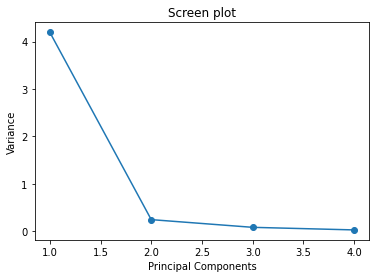

In [ ]:
# Screen plot은 주성분에 대한 분산을 시각화한 그래프이다.
plt.title("Screen plot")
plt.xlabel("Principal Components")
plt.ylabel("Variance")
plt.plot(range(1, len(V)+1), V, 'o-')
plt.show()

### 변환된 그래프 그리기
- PC1과 PC2를 축으로 하는 그래프 그리기

In [ ]:
species = {s: idx for idx, s in enumerate(set(answers))} # 아래의 그래프에서 iris의 종에 따라 색을 구분하기 위한 딕셔너리를 생성한다.

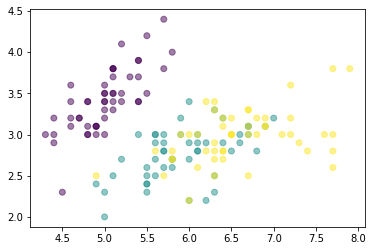

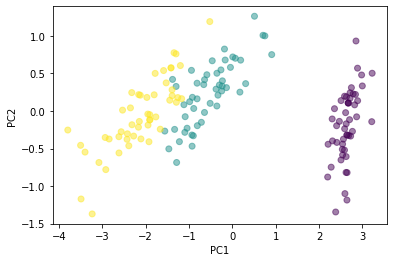

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=[species[ans] for ans in answers], alpha=0.5)
plt.show()

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.scatter(K[:, 0], K[:, 1], c=[species[ans] for ans in answers], alpha=0.5) # K[:, 0]과 K[:, 1]은 각각 첫번째 및 두번째 주성분 축에 대한 점들의 좌표를 의미한다.
plt.show()

- 위에서 첫번째 그래프는 차원 축소를 하기 전의 2개의 차원을 이용하여 분산도를 그린 것이고, 두번째 그래프는 데이터의 차원을 PC1과 PC2로 축소한 분산도를 그린 것이다.
- 차원 축소하기 전의 데이터는 그래프와 같이 겹쳐서 분할하기 어려운 형태를 보이지만, 주성분에 대해 차원 축소한 데이터는 비교적 분할이 쉽게 될 수 있는 형태를 보인다.